In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torcheval.metrics.functional import r2_score

In [4]:
from src.models import FCN, FCN_with_last_activation, FCN_with_parallel_branch
from src.data_handler import DataHandler, DataHandlerForAllSimulations, RandomSamplingDataHandler
from src.experiment_run import RunAllSimulations, Run
from src.constants import TIMESTEP_SCALE, GAMMA_SCALE, N_SCALE
from src.physics_loss import physics_loss_fixed_gamma_n, physics_loss_varied_gamma_n

In [5]:
def run_eval(x, y, run):
    print("R^2 score of the model: ", run.score().item())
    plt.plot(x, run.model(x).detach().numpy(), label="predicted ionization fraction")
    plt.plot(x, y, label="true ionization fraction")
    plt.xlabel("timestep")
    plt.ylabel("x_i")
    plt.legend()

def all_run_eval(run):
    r2_scores, pred_best, y_best, pred_worst, y_worst = run.test()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
    ax[0].plot(pred_best.detach().numpy(), label="Prediction")
    ax[0].plot(y_best.detach().numpy(), label="Target")
    ax[0].set_xlabel("Timestep")
    ax[0].set_ylabel("Reionization rate")
    ax[0].set_title(f"The most accurate approximation, R2={np.max(r2_scores)}")
    ax[0].legend()
    ax[1].plot(pred_worst.detach().numpy(), label="Prediction")
    ax[1].plot(y_worst.detach().numpy(), label="Target")
    ax[1].set_xlabel("Timestep")
    ax[1].set_ylabel("Reionization rate")
    ax[1].set_title(f"The least accurate approximation, R2={np.min(r2_scores)}")
    ax[1].legend()
    plt.show()
    return r2_scores

In [7]:
train_t_steps = 10000

# define the Universe time
train_u_time = np.arange(train_t_steps)

In [8]:
test_t_steps = 50
test_u_time = np.arange(test_t_steps)

In [9]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [10]:
train_data = np.load('data/test1.npy').T
train_data.shape

(2000, 10000)

In [11]:
train_params = pd.read_csv('data/params1.txt', sep=' ')
train_params = train_params.values
train_params.shape

(2000, 2)

In [12]:
test_data = np.load('data/sim_cosm/xHII_z9.026.npy')
test_data = test_data[:test_t_steps, :test_t_steps, :test_t_steps]

In [13]:
test_gamma = np.load("data/sim_cosm/gamma_z9.026.npy")
test_ngas = np.load("data/sim_cosm/ngas_z9.026.npy")

test_gamma = test_gamma[:test_t_steps, :test_t_steps, :test_t_steps]
test_ngas = test_ngas[:test_t_steps, :test_t_steps, :test_t_steps]

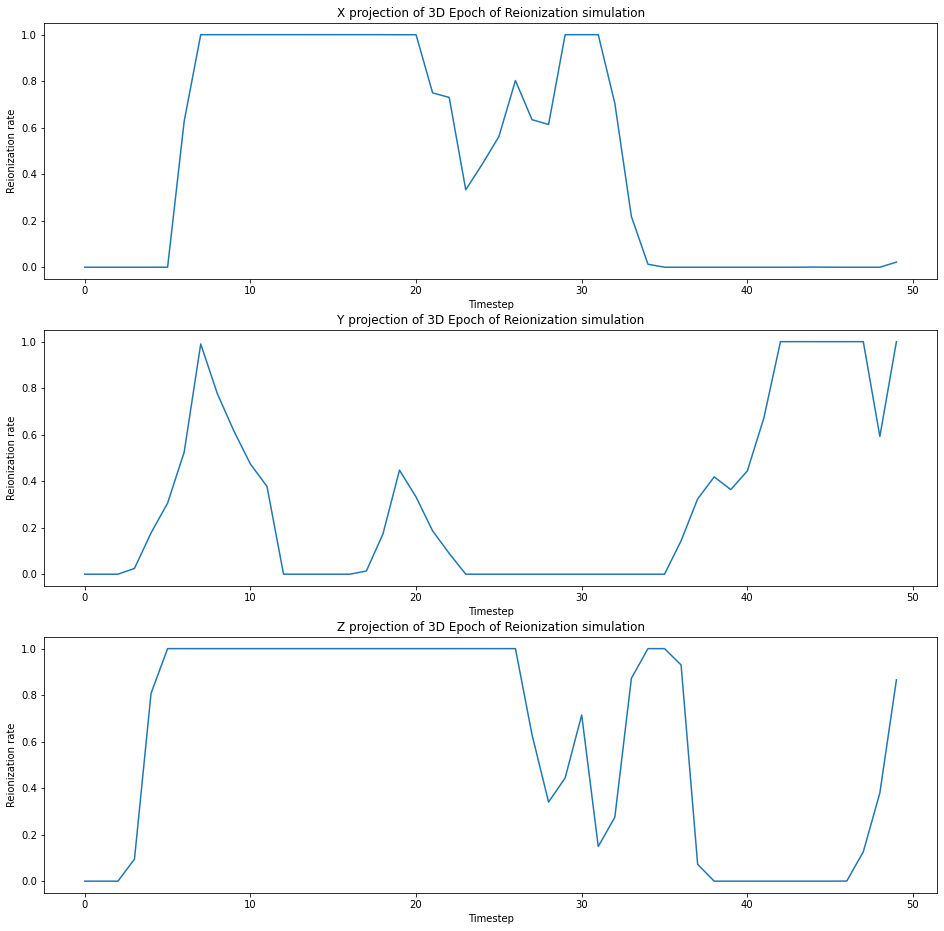

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16,16))
ax[0].plot(test_data[:, 0, 0])
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Reionization rate")
ax[0].set_title(f"X projection of 3D Epoch of Reionization simulation")
ax[1].plot(test_data[0, :, 0])
ax[1].set_xlabel("Timestep")
ax[1].set_ylabel("Reionization rate")
ax[1].set_title(f"Y projection of 3D Epoch of Reionization simulation")
ax[2].plot(test_data[0, 0, :])
ax[2].set_xlabel("Timestep")
ax[2].set_ylabel("Reionization rate")
ax[2].set_title(f"Z projection of 3D Epoch of Reionization simulation")
plt.show()

Training on the previosly analyzed simulations

In [15]:
train_timesteps = torch.tensor(train_u_time).float().view(-1,1)
y_train = torch.tensor(train_data).float()

In [16]:
x_train = torch.zeros((2000, 10000, 3)) # n_simulations * n_timesteps * feature_dim
for i, row in enumerate(train_params):
    row = row * np.array([N_SCALE, GAMMA_SCALE])
    row_2d = np.broadcast_to(row, (10000, 2))
    row_2d = torch.tensor(row_2d).float()
    x_train[i] = torch.hstack((train_timesteps * TIMESTEP_SCALE, row_2d))
print(x_train[0, 0:5, :])

tensor([[0.0000e+00, 1.6522e-02, 1.6896e+00],
        [1.0000e-04, 1.6522e-02, 1.6896e+00],
        [2.0000e-04, 1.6522e-02, 1.6896e+00],
        [3.0000e-04, 1.6522e-02, 1.6896e+00],
        [4.0000e-04, 1.6522e-02, 1.6896e+00]])


  0%|          | 0/10 [00:00<?, ?it/s]

Total num of the batches:  1800


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


R2 best simulation:  0.9953621
R2 worst simulation:  -2.623201


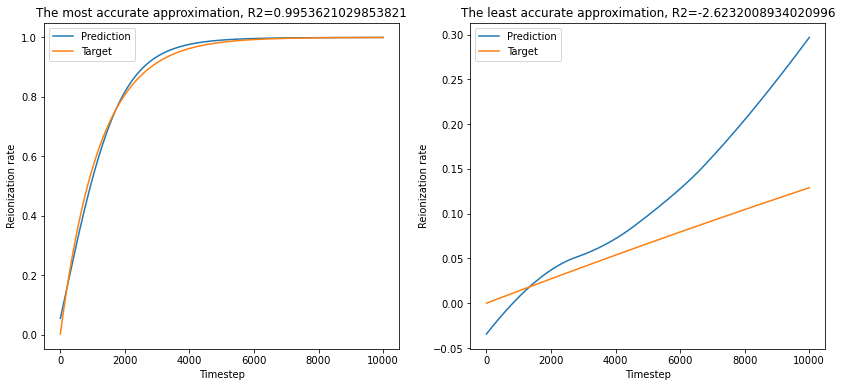

In [17]:
model = FCN_with_last_activation([3, 8, 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_no_physics_for_normal_simulations')

run.data_handler = DataHandlerForAllSimulations(x_train, y_train, resample_ood_runs=True, ood_weight=0., normal_weight=1.)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(10)
r2_scores_on_validation = all_run_eval(run)

Test simulation: we aim to approximate X, Y and Z projections of test EoR simulation by trained PINN

In [18]:
test_timesteps = torch.tensor(test_u_time).float().view(-1,1)
xyz_projections = np.vstack([test_data[:, 0, 0], test_data[0, :, 0], test_data[0, 0, :]])
y_test = torch.tensor(xyz_projections).float()

In [19]:
x_test = torch.zeros((3, 50, 3)) # n_projections * n_timesteps * feature_dim
test_params = np.vstack([test_ngas[:, 0, 0], test_gamma[:, 0, 0], 
                        test_ngas[0, :, 0], test_gamma[0, :, 0], 
                        test_ngas[0, 0, :], test_gamma[0, 0, :]]).T
test_params = torch.tensor(test_params).float()
for i in range(3):
    proj_params = test_params[:, 2*i:2*(i+1)]
    proj_params = proj_params * np.array([N_SCALE, GAMMA_SCALE])
    x_test[i] = torch.hstack((test_timesteps * TIMESTEP_SCALE, proj_params))
print(x_test[0, 0:5, :])

tensor([[0.0000e+00, 1.1629e-01, 0.0000e+00],
        [1.0000e-04, 1.3394e-01, 0.0000e+00],
        [2.0000e-04, 1.2730e-01, 0.0000e+00],
        [3.0000e-04, 1.7597e-01, 0.0000e+00],
        [4.0000e-04, 1.1848e-01, 1.9661e-07]])


R2 best simulation:  -0.5948014
R2 worst simulation:  -0.7357409


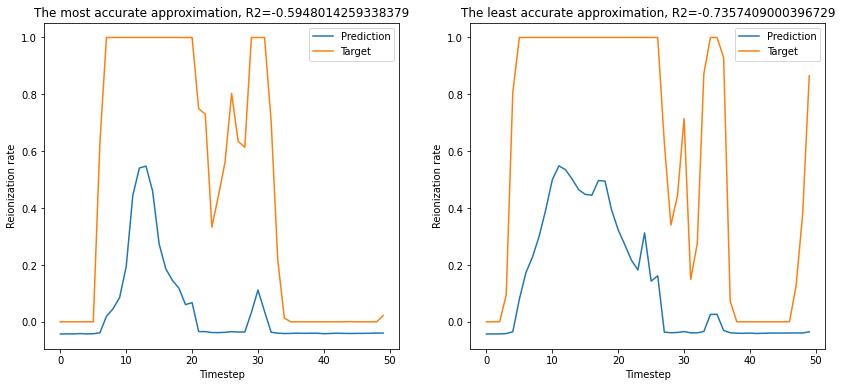

In [20]:
run.data_handler = DataHandlerForAllSimulations(x_test, y_test, resample_ood_runs=False, train_fraction=0.0, 
                                                 ood_weight=0., normal_weight=1.)
r2_scores_on_validation = all_run_eval(run)

Parallel branch

In [21]:
x_test = torch.zeros((3, 50, 3)) # n_projections * n_timesteps * feature_dim
test_params = np.vstack([test_ngas[:, 0, 0], test_gamma[:, 0, 0], 
                        test_ngas[0, :, 0], test_gamma[0, :, 0], 
                        test_ngas[0, 0, :], test_gamma[0, 0, :]]).T
test_params = torch.tensor(test_params).float()
# scaling factors along different axis are different 
scaling_factors = [N_SCALE, GAMMA_SCALE * 1e1, N_SCALE, GAMMA_SCALE * 1e2, N_SCALE, GAMMA_SCALE * 1e2]
for i in range(3):
    proj_params = test_params[:, 2*i:2*(i+1)]
    proj_params = proj_params * np.array(scaling_factors[2*i:2*(i+1)])
    x_test[i] = torch.hstack((test_timesteps * TIMESTEP_SCALE, proj_params))
print(x_test[1, 0:5, :])

tensor([[0.0000e+00, 1.1629e-01, 0.0000e+00],
        [1.0000e-04, 1.2600e-01, 0.0000e+00],
        [2.0000e-04, 1.4583e-01, 0.0000e+00],
        [3.0000e-04, 2.2121e-01, 6.7135e-02],
        [4.0000e-04, 2.1922e-01, 3.1145e-01]])


Without physics loss

In [22]:
parallel_model = FCN_with_parallel_branch([1, 8, 8, 8], [2, 8, 8, 8], [ 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(parallel_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_with_physics_parallel_branches')

run.data_handler = DataHandlerForAllSimulations(x_train, y_train, resample_ood_runs=True, ood_weight=0., normal_weight=1.)
run.model = parallel_model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None 

run.train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

Total num of the batches:  1800


100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


R2 best simulation:  0.99883133
R2 worst simulation:  -61.211132


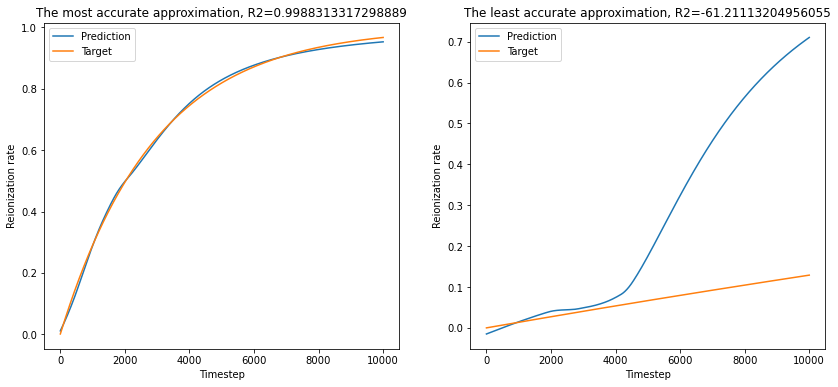

In [23]:
r2_scores_on_validation = all_run_eval(run)

R2 best simulation:  0.6015032
R2 worst simulation:  0.5027708


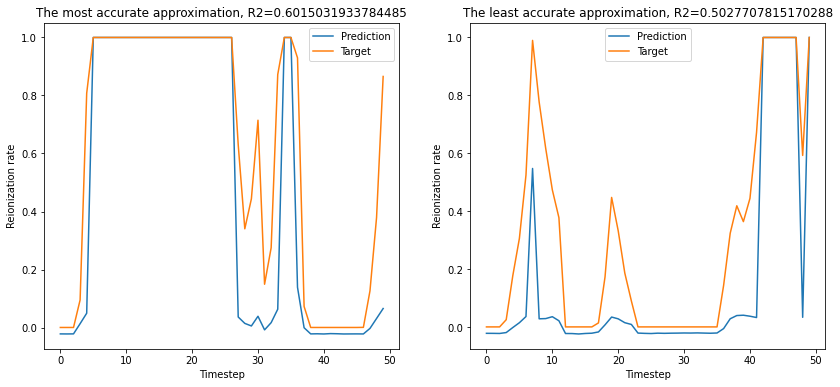

In [24]:
run.data_handler = DataHandlerForAllSimulations(x_test, y_test, resample_ood_runs=False, train_fraction=0.0, 
                                                 ood_weight=0., normal_weight=1.)
r2_scores_on_test = all_run_eval(run)

With physics loss

In [25]:
parallel_model = FCN_with_parallel_branch([1, 8, 8, 8], [2, 8, 8, 8], [ 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(parallel_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_with_physics_parallel_branches')

run.data_handler = DataHandlerForAllSimulations(x_train, y_train, resample_ood_runs=True, ood_weight=0., normal_weight=1.)
run.model = parallel_model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_varied_gamma_n(x, y, loss_coef=1e5)

run.train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

Total num of the batches:  1800


100%|██████████| 10/10 [01:23<00:00,  8.35s/it]


R2 best simulation:  0.7325694
R2 worst simulation:  0.58964664


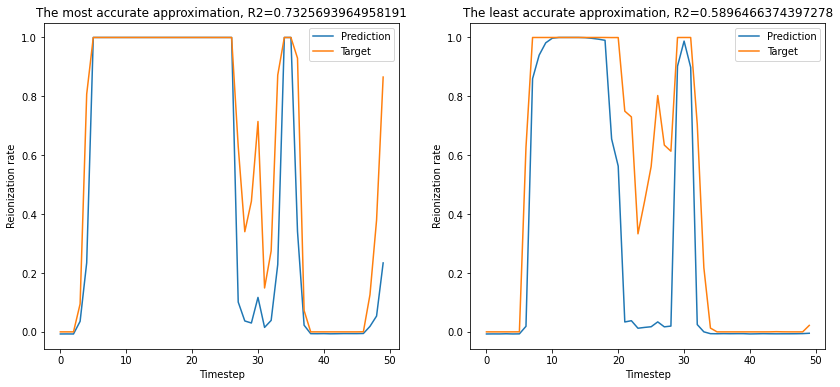

In [26]:
run.data_handler = DataHandlerForAllSimulations(x_test, y_test, resample_ood_runs=False, train_fraction=0.0, 
                                                 ood_weight=0., normal_weight=1.)
r2_scores_on_test = all_run_eval(run)